In [1]:
#import libraries and functions
import numpy as np
from arqtic.program import Program, random_bitstring
from arqtic.hamiltonians import Ising_Hamiltonian
from arqtic.arqtic_for_ibm import run_ibm
import arqtic.QITE as qite
import qiskit as qk
from qiskit import Aer, IBMQ, execute
import matplotlib.pyplot as plt

In [2]:
#interfacing with IBM
########################################
#The following only needs to be run if this you very first time running this pynb, comment out all subsequent times
#qk.IBMQ.save_account('API_token_here')
#qk.IBMQ.load_account()
########################################

#set up simulator
simulator = Aer.get_backend('statevector_simulator')
#simulator = Aer.get_backend('qasm_simulator')
#set optimization level for transpiler
opt_level = 3

In [3]:
#define post-processing functions
#get amouot of work from QC results
def get_work(results, shots):
    work = 0
    for result in results:
        state_vec = result[0]
        count = result[1]
        work_comp = 0
        for i in range(len(state_vec)):
            if (state_vec[i] == 0):
                work_comp += 1
            else:
                work_comp += -1
        work_comp *= count
        work += work_comp
    work = work/shots
    return work

In [19]:
#define observable ZI + IZ
Z = np.array([[1.0,0.0],[0.0,-1.0]])
ZI = np.kron(Z, np.eye(2))
IZ = np.kron(np.eye(2), Z)
#two qubits
#observable = ZI + IZ
#one qubit
observable = Z
print(observable)

[[ 1.  0.]
 [ 0. -1.]]


In [20]:
def run_ibm_WF_sim(backend, prog, opt_level=1):
    nqubits = prog.nqubits
    #declare registers
    q_regs = qk.QuantumRegister(nqubits, 'q')
    c_regs = qk.ClassicalRegister(nqubits, 'c')
    #make program into IBM circuit
    ibm_circuit = qk.QuantumCircuit(q_regs, c_regs)
    for gate in prog.gates:
        #print(gate.name)
        #print(gate.qubits)
        #print(gate.angles)
        if (gate.name == "X"):
            ibm_circuit.x(gate.qubits)
        if (gate.name == "Y"):
            ibm_circuit.y(gate.qubits)
        if (gate.name == "Z"):
            ibm_circuit.z(gate.qubits)
        if (gate.name == "H"):
            ibm_circuit.h(gate.qubits)
        if (gate.name == "RZ"):
            ibm_circuit.rz(gate.angles[0], gate.qubits)
        if (gate.name == "RX"):
            ibm_circuit.rx(gate.angles[0], gate.qubits)
        if (gate.name == "CNOT"):
            ibm_circuit.cx(gate.qubits[0], gate.qubits[1])
    ibm_circ = qk.transpile(ibm_circuit, backend=backend, optimization_level=opt_level)
    #simulator execution
    result = qk.execute(ibm_circ, backend).result()
    statevector = result.get_statevector(ibm_circ)
    return statevector

In [21]:
#define system variables
N = 1 #number of qubits
Jz = 0.1 #ising interaction strength !!! Not used for 1-qubit
mu_x = 0.3 #transverse magnetic field strength
param_free_ham = Ising_Hamiltonian(N, Jz, [mu_x, 0, 0]) #parameter-free Hamiltonian
ising_ham0 = Ising_Hamiltonian(N, Jz, [mu_x, 0, 0]) #Hamiltonian at beginning of parameter sweep

#define simulation variables
tau = 10 #total trajectory time to evolve lambda from 0 to 1
dtau = 1.0 #time-step for trajectory
num_steps = int(tau/dtau)
T = 100 #total number of trajectories
dt =  dtau #timestep for Trotter approximation: setting equal to dtau means one trotter-step per time-step in evolution
lambda_protocol = np.linspace(1.0, 0,num_steps)
print(lambda_protocol)
dldt = (lambda_protocol[1]-lambda_protocol[0])/dtau # d(lambda)/d(tau)
print(dldt) 
shots = 1000

#define QITE variables
beta = 4.0 #inverse temperature of systems
dbeta = 0.2 #step-size in beta for QITE
domain = 1 #domain of opertators for QITE

[1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ]
-0.11111111111111116


In [22]:
#create program to move to x-basis for measurement
prog_xBasis = Program(N)
prog_xBasis.get_x_basis_prog()

#first state should be random
measured_metts_state = random_bitstring(N)
#subsequent entries are derived from running QMETTS on the previously derived
#state and measuring a random observable to get the state for the subsequent run

#need to sum work over each trajectory and then average over works
work = []
#loop over trajectories
for i in range(T):
    #print(i)
    psi0 = qite.get_state_from_string(measured_metts_state)
    #print("psi is: ", psi0)
    prog_TS = Program(N)
    prog_TS.make_ps_prog(measured_metts_state)
    #print(measured_metts_state)
    #print("PS circuit")
    #prog_TS.print_list()
    prog_qite = Program(N)
    #note QITE algorithm should evolve state by beta/2 for temperature beta
    prog_qite.make_QITE_prog(ising_ham0, beta/2.0, dbeta, domain, np.asarray(psi0), 1.0)
    #print("QITE circuit")
    #prog_qite.print_list()
    prog_TS.append_program(prog_qite)
    #print("TS circuit")
    #prog_TS.print_list()
    #make and run qmetts program
    prog_qmetts = Program(N)
    prog_qmetts.append_program(prog_TS)
    #make random measurement operator
    if (i%2 == 0):
        prog_qmetts.append_program(prog_xBasis)
    #print("QMETTS circuit")
    #prog_qmetts.print_list()
    #QMETTS_statevector = run_ibm_WF_sim(simulator, prog_qmetts, opt_level)
    #print("QMETTS_statevector is", QMETTS_statevector)
    #collapse statevector
    results = run_ibm(simulator, prog_qmetts, opt_level)
    #update measured metts state for next trajectory
    measured_metts_state = results[0][0]
    #print("collapsed state is: ", measured_metts_state)
    #make and run JE program
    prog_JE = Program(N)
    prog_JE.append_program(prog_TS)
    #loop over time-steps in trajectory i
    work_i = 0    
    for step in range(num_steps):
        #print(step)
        #make Hamilton Evolution program for given time-step of given trajectory
        prog_hamEvol = Program(N)
        prog_hamEvol.make_hamEvol_prog(step, dtau, dt, lambda_protocol, param_free_ham)
        #complete JE program: combing IPS preparation, QITE, and Hamiltonian evolution
        prog_JE.append_program(prog_hamEvol)
        prog_JE.append_program(prog_xBasis)
        JE_statevector = run_ibm_WF_sim(simulator, prog_JE, opt_level)
        #print("JE_statevector is: ", JE_statevector)
        #how to get work with qasm_simulator:
        #results = run_ibm(simulator, prog_JE, shots, opt_level)
        #work_i += dldt*dtau*(-mu_x)*get_work(results, shots)
        #how to get work with statevector simulator
        expectation_value = np.dot(np.conj(JE_statevector), np.dot(observable, JE_statevector))
        #print("expectation_value is: ",expectation_value)
        work_i += expectation_value*(-mu_x)*dldt*dtau
    work.append(work_i)
    #print("work is: ", work_i)

print("total work is: ", np.mean(work))

#FE = get_free_energy(work)  !!This function not yet implemented

total work is:  (-0.004159035837471138+0j)


In [23]:
print(work)

[(-0.005363096514744162+0j), (-0.0038389690751580545+0j), (-0.005363096514744162+0j), (-0.0038389690751580545+0j), (-0.005363096514744162+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.005363096514744162+0j), (-0.005363096514744162+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.005363096514744162+0j), (-0.005363096514744162+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.005363096514744162+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.0038389690751580545+0j), (-0.005363096514744162+0j), (-0.0038389690751580545+0j), (-0.003838969075158054

In [24]:
#free energy is 
work_sum = 0
for i in range(T):
    work_sum += np.exp(-beta*work[i])
work_avg = work_sum/T
free_eng = (-1/beta)*np.log(work_avg)
print(free_eng)

(-0.004159807505548053+0j)


/opt/anaconda3/envs/qiskit_env/lib/python3.8/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/anaconda3/envs/qiskit_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/qiskit_env/lib/python3.8/site-packages/matplotlib/transforms.py:1966: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


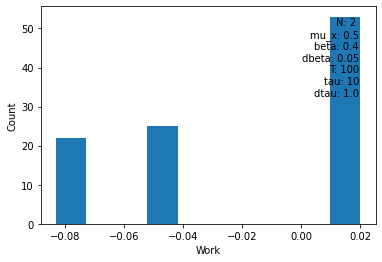

In [21]:
#plot data and save figure
nbins = 10
plt.xlabel('Work')
plt.ylabel('Count')
data_str = f"N: {N} "+"\n"+f"mu_x: {mu_x}"+"\n"+f"beta: {beta}"+"\n"+f"dbeta: {dbeta}"+"\n"+f"T: {T}"+"\n"+f"tau: {tau}"+"\n"+f"dtau: {dtau}" 
ax = plt.gca()
ax.text(0.95, 0.95, data_str,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
plt.hist(work, bins = nbins)

#May or may not want to limit x-axis
#plt.xlim(-0.1,0.1)
fname = 'mu_x_{}_beta_{}_hist.png'.format(mu_x, beta)
#plt.savefig(fname)
plt.show()